['20-40_DRT.csv', '20-40_WB-ras_DRT_1e-4_18e-1.txt', '20-40_WB-ras_error.txt', '20-40_WB-ras_fit.txt', '21-01.TXT', '21-40.TXT', '22-00.TXT', '22-40.TXT', 'Gaussian', 'medium_substrated', 'Peak_amplitude.csv', 'Peak_center.csv', 'Peak_FWHM.csv', 'Peak_sigma.csv', 'raw']

 20-40_DRT.csv


Text(0.5, 1.0, '20-40_DRT')

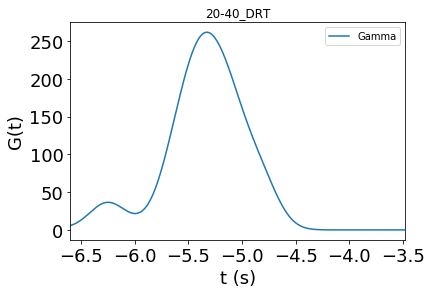

In [10]:
# !/usr/bin python3
# Fukun Shi, 2019.04.22
# https://chrisostrouchov.com/post/peak_fit_xrd_python/
'''
基于最小二乘lmfit做multi-peaks分析
'''
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal

from lmfit import models

%matplotlib inline

#######################
# 1 输入需要拟合的曲线#

fl = 3e3
fh = 4e6
taul = 1/fh
tauh = 1/fl

maindir = 'D:\\Nutstore\\PhD\\Experiment\\EIS_data_transform\\WB-ras\\'

###############################
filepath = maindir# + '\\DRT 60ns'          # 第一步读取文件
filenames = os.listdir(filepath)
print(filenames)
domain = os.path.abspath(filepath)
num = 0                                   # 需要读取的文件
info = os.path.join(domain,filenames[num]) # 读取文件路径
print('\n', filenames[num])
###############################
filename = filenames[num].strip('.csv')

filepath0 = maindir + '\\Gaussian\\' + filename + '_Gaussian.xlsx'  # 第二步保存拟合的高斯函数
filepath1 = maindir + '\\Gaussian\\' + 'Peaks\\' + filename + '_Peaks.xlsx'     # 第三步输出结果

drt = pd.read_csv(info,header=2)
drt.columns = ['Gamma','tau']
drt = drt.loc[(drt.tau>=taul)&(drt.tau<=tauh)]
drt.reset_index(inplace=True,drop=True)
drt['tau'] = np.log10(drt.tau.values) # 将横坐标化为log10(t)
#print(drt)
drt.plot(x='tau',y='Gamma',logx=False,  fontsize=18) 
plt.ylabel('G(t)',fontsize=18)
plt.xlabel('t (s)',fontsize=18)
plt.title(filename)

3
End


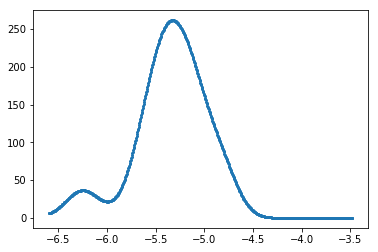

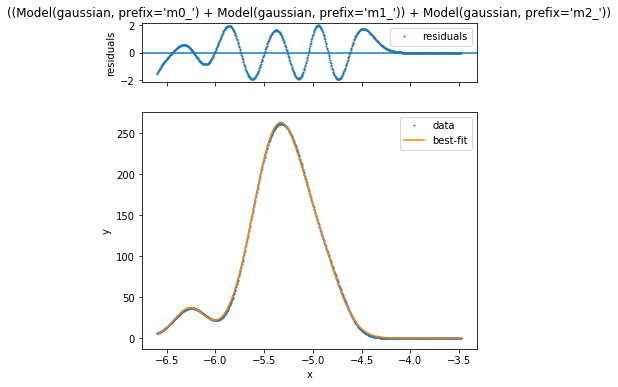

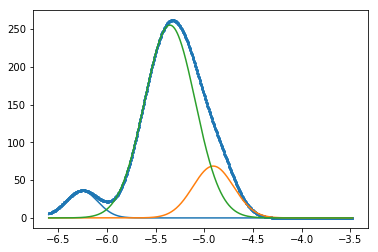

In [11]:
#######################################################
# 2 用find_peaks_cwt寻找peaks.从上图中人工判断多少个峰#

##########################################################################
# 利用lmfit拟合double Gaussian-peaks。先定义parameters，然后用fit函数拟合#
def generate_model(spec):
    '''定义适合使用lmfit拟合的复合函数模型，包括高斯，洛伦茨和福格特函数'''
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):              # enumerate序列化输入的list，用于分离序列号和实例值
        prefix = f'm{i}_'                                       # f字符串格式化语法，类似format和%。prefix适用于区分复合函数内的同名参数
        model = getattr(models, basis_func['type'])(prefix=prefix) 
                                                                # models包含了lmfit内建的函数库。getattr用于提取type对应的函数。选定函数
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: 
                                                                # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)# 用于make_params，指定参数的尺度和范围
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
                                                                # default guess is horrible!! do not use guess()。定义默认初始值
            default_params = {                                  # 基于XRD的理解而选定的初始值
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:                                # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {})) # 确定参数
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params


def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    '''寻找peaks，model_indicies是输入复合函数的索引'''
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths) # 寻找peaks的函数
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {                                    # 参数初始值设定
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

spec = {
    'x': drt.tau.values,
    'y': drt['Gamma'].values,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}


peaks_found = update_spec_from_peaks(spec, [0, 1, 2], peak_widths=(1e-5, 1e-3)) # 找出peaks
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)                          # x是输入的XRD横坐标，y是纵坐标值
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')  # 画出竖直虚线标出peaks位置。

model, params = generate_model(spec)               # 生成复合函数
output = model.fit(spec['y'], params, x=spec['x']) # 拟合
fig, gridspec = output.plot(data_kws={'markersize':  1})

fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])  # 得到各个拟合函数
Gau = pd.DataFrame()                              # 得到每个子函数的值
Gau['tau'] = spec['x']
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])      # 画出各个复合函数的图
    Gau['m'+str(i)] = components[f'm{i}_']
                                 
#Gau.to_excel(filepath0,index=False)            
print('End')

In [12]:
#####################
# 3 输出最佳拟合结果#
def print_best_values(spec, output):
    model_params = {
        'GaussianModel':   ['amplitude', 'sigma'],
        'LorentzianModel': ['amplitude', 'sigma'],
        'VoigtModel':      ['amplitude', 'sigma', 'gamma']
    }
    best_values = output.best_values
    print('center    model   amplitude     sigma      gamma')
    for i, model in enumerate(spec['model']):
        prefix = f'm{i}_'
        values = ', '.join(f'{best_values[prefix+param]:8.3f}' for param in model_params[model["type"]])
        print(f'[{best_values[prefix+"center"]:3.3f}] {model["type"]:16}: {values}')

print_best_values(spec, output)


center    model   amplitude     sigma      gamma
[-6.261] GaussianModel   :   14.920,    0.164
[-4.908] GaussianModel   :   35.826,    0.208
[-5.354] GaussianModel   :  166.279,    0.260


In [ ]:
# 3 定义先验params
spec = {
    'x': df.index.values,
    'y': df['count'].values,
    'model': [
        {
            'type': 'GaussianModel',
            'params': {'center': 34.11, 'height': 13.08, 'sigma': 0.1},
            'help': {'center': {'min': 33.5, 'max': 34.5}}
        },
        {
            'type': 'VoigtModel',
            'params': {'center': 36.37, 'height': 30.94, 'sigma': 0.1, 'gamma': 0.1},
            'help': {'center': {'min': 35, 'max': 37}}
        },
        {'type': 'GaussianModel', 'params': {'center': 39.57, 'height': 76.56, 'sigma': 0.1}},
        {
            'type': 'GaussianModel',
            'params': {'center': 40.85, 'height': 30.77, 'sigma': 0.1},
            'help': {'center': {'min': 40, 'max': 42}}
        },
        {'type': 'VoigtModel', 'params': {'center': 41.73, 'height': 38.44, 'sigma': 0.05, 'gamma': 0.15}},
        {
            'type': 'GaussianModel',
            'params': {'center': 42.55, 'height': 45.29, 'sigma': 0.1},
            'help': {'center': {'min': 42, 'max': 43}}
        },
        {'type': 'GaussianModel', 'help': {'center': {'max': 39.2}}},
        #{'type': 'GaussianModel'},
        #{'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})

fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])